# pyarrow.dataset.Dataset
## Lazy Loading & Streaming:
    Reads data in batches only when needed
    Minimizes memory usage by avoiding loading the entire dataset at once
## Predicate Pushdown:
    Applies filters at the data source level, reducing I/O by reading only relevant rows
## Multi-Format Support:
    Can read/write multiple file formats such as Parquet, Feather, CSV, and ORC

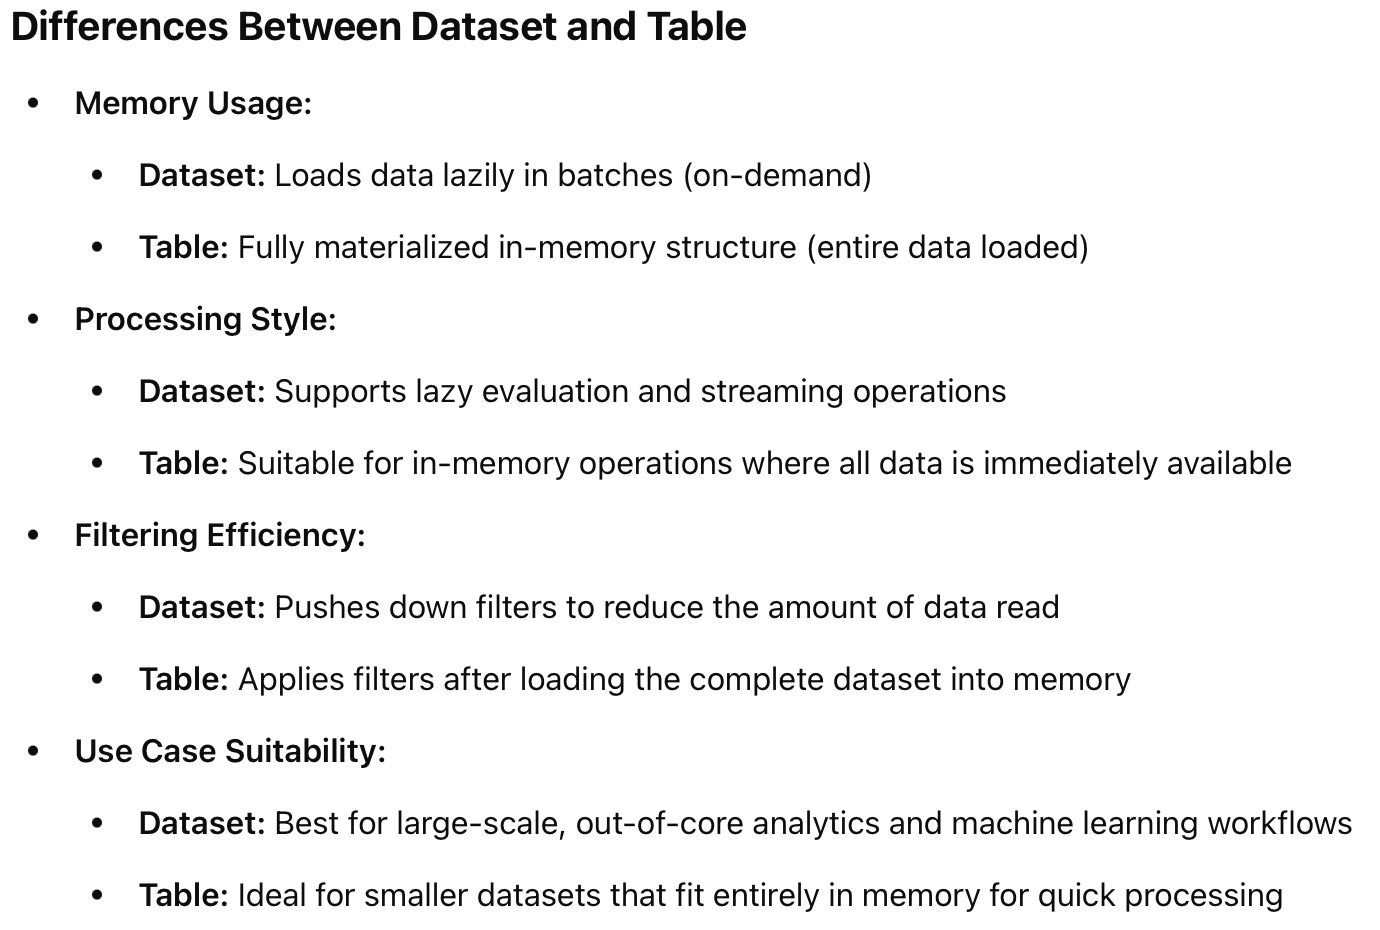

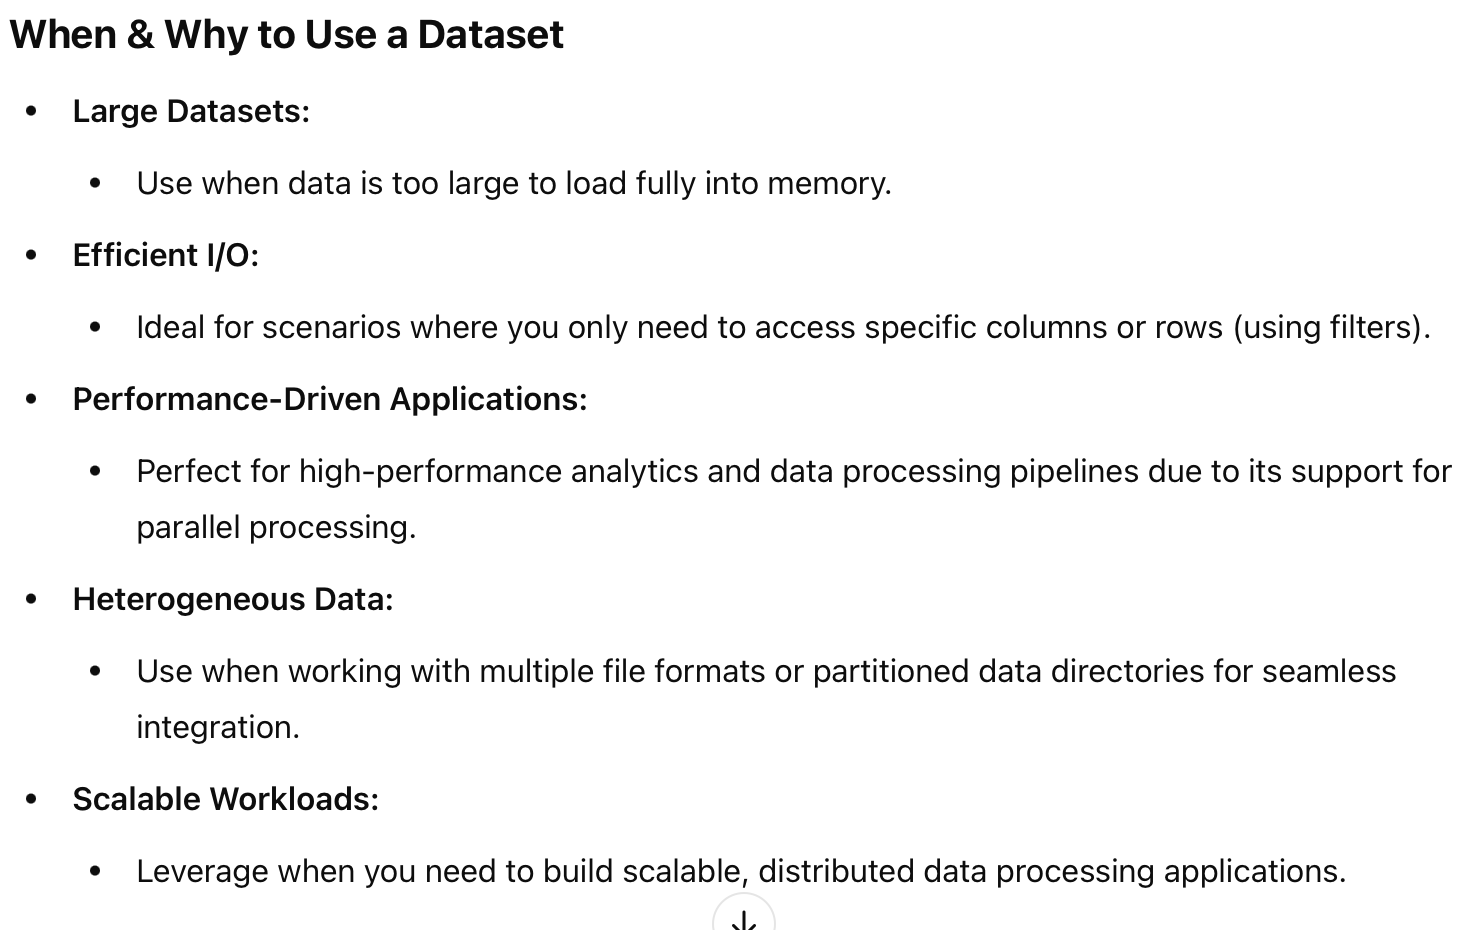

In [1]:
import tempfile

import pathlib

import pyarrow as pa

import pyarrow.parquet as pq

import numpy as np

base = pathlib.Path(tempfile.mkdtemp(prefix="pyarrow-"))

(base / "parquet_dataset").mkdir(exist_ok=True)

table = pa.table({'a': range(10), 'b': np.random.randn(10), 'c': [1, 2] * 5})

pq.write_table(table.slice(0, 5), base / "parquet_dataset/data1.parquet")

pq.write_table(table.slice(5, 10), base / "parquet_dataset/data2.parquet")

In [2]:
base

PosixPath('/var/folders/s8/1949x5zs6xj63rt734q09jzr0000gn/T/pyarrow-6mx45cyo')

In [3]:
import pyarrow.dataset as ds

dataset = ds.dataset(base / "parquet_dataset", format="parquet")

dataset

In [4]:
dataset.files

['/var/folders/s8/1949x5zs6xj63rt734q09jzr0000gn/T/pyarrow-6mx45cyo/parquet_dataset/data1.parquet',
 '/var/folders/s8/1949x5zs6xj63rt734q09jzr0000gn/T/pyarrow-6mx45cyo/parquet_dataset/data2.parquet']

In [5]:
dataset.schema

a: int64
b: double
c: int64

In [7]:
dataset.to_table()

pyarrow.Table
a: int64
b: double
c: int64
----
a: [[0,1,2,3,4],[5,6,7,8,9]]
b: [[1.135482668339853,0.0905212600439889,1.3771955855286007,-0.840337846972223,2.0895215896792743],[-1.0399055095125538,-0.5221923517501412,0.3396677613480518,-1.0864218441096198,-0.1191921091515184]]
c: [[1,2,1,2,1],[2,1,2,1,2]]

In [8]:
dataset.to_table().to_pandas()

,a,b,c
0,0,1.135483,1
1,1,0.090521,2
2,2,1.377196,1
3,3,-0.840338,2
4,4,2.089522,1
5,5,-1.039906,2
6,6,-0.522192,1
7,7,0.339668,2
8,8,-1.086422,1
9,9,-0.119192,2


In [9]:
import pyarrow.feather as feather

feather.write_feather(table, base / "data.feather")

In [12]:
base

PosixPath('/var/folders/s8/1949x5zs6xj63rt734q09jzr0000gn/T/pyarrow-6mx45cyo')

In [11]:
dataset = ds.dataset(base / "data.feather", format="feather")

dataset.to_table().to_pandas().head()

,a,b,c
0,0,1.135483,1
1,1,0.090521,2
2,2,1.377196,1
3,3,-0.840338,2
4,4,2.089522,1


Dictionary encoding is useful for columns with many repeated values (like categorical data). It reduces memory usage by storing a single copy of each unique value.

In [37]:
parquet_format = ds.ParquetFileFormat(read_options={'dictionary_columns': ['a']})
dataset = ds.dataset(base / "parquet_dataset", format=parquet_format)
dataset.to_table().to_pandas()

,a,b,c
0,0,1.135483,1
1,1,0.090521,2
2,2,1.377196,1
3,3,-0.840338,2
4,4,2.089522,1
5,5,-1.039906,2
6,6,-0.522192,1
7,7,0.339668,2
8,8,-1.086422,1
9,9,-0.119192,2


In [14]:
parquet_format = ds.ParquetFileFormat(read_options={'dictionary_columns': ['a']})
ds.dataset(base / "parquet_dataset", format=parquet_format)

In [15]:
dataset = ds.dataset(base / "parquet_dataset", format="parquet")

dataset.to_table(columns=['a', 'b']).to_pandas()

,a,b
0,0,1.135483
1,1,0.090521
2,2,1.377196
3,3,-0.840338
4,4,2.089522
5,5,-1.039906
6,6,-0.522192
7,7,0.339668
8,8,-1.086422
9,9,-0.119192


In [16]:
dataset.to_table(filter=ds.field('a') >= 7).to_pandas()


,a,b,c
0,7,0.339668,2
1,8,-1.086422,1
2,9,-0.119192,2


In [17]:
dataset.to_table(filter=ds.field('c') == 2).to_pandas()

,a,b,c
0,1,0.090521,2
1,3,-0.840338,2
2,5,-1.039906,2
3,7,0.339668,2
4,9,-0.119192,2


,a,b,c
0,1,0.090521,2
1,2,1.377196,1
2,3,-0.840338,2


In [22]:
dataset.to_table(filter=(ds.field('a') > ds.field('b')) & (ds.field('b') > 1)).to_pandas()


,a,b,c
0,2,1.377196,1
1,4,2.089522,1


In [23]:
projection = {
    "a_renamed": ds.field("a"),
    "b_as_float32": ds.field("b").cast("float32"),
    "c_1": ds.field("c") == 1,
}


dataset.to_table(columns=projection).to_pandas().head()

,a_renamed,b_as_float32,c_1
0,0,1.135483,True
1,1,0.090521,False
2,2,1.377196,True
3,3,-0.840338,False
4,4,2.089522,True


In [24]:
projection = {col: ds.field(col) for col in dataset.schema.names}

projection.update({"b_large": ds.field("b") > 1})

dataset.to_table(columns=projection).to_pandas().head()

,a,b,c,b_large
0,0,1.135483,1,True
1,1,0.090521,2,False
2,2,1.377196,1,True
3,3,-0.840338,2,False
4,4,2.089522,1,True


In [ ]:
part = ds.partitioning(
    pa.schema([("year", pa.int16()), ("month", pa.int8()), ("day", pa.int32())]),
    flavor="hive"
)
dataset = ds.dataset(..., partitioning=part)

In [ ]:
part = ds.partitioning(field_names=["year", "month", "day"])

In [25]:
dataset = ds.dataset("s3://voltrondata-labs-datasets/nyc-taxi/")

In [26]:
from pyarrow import fs

s3  = fs.S3FileSystem(region="us-east-2")
dataset = ds.dataset("voltrondata-labs-datasets/nyc-taxi/", filesystem=s3)

In [27]:
table = pa.table({'col1': range(3), 'col2': np.random.randn(3)})

(base / "parquet_dataset_manual").mkdir(exist_ok=True)

pq.write_table(table, base / "parquet_dataset_manual" / "data_2018.parquet")

pq.write_table(table, base / "parquet_dataset_manual" / "data_2019.parquet")

In [28]:
from pyarrow import fs

schema = pa.schema([("year", pa.int64()), ("col1", pa.int64()), ("col2", pa.float64())])

dataset = ds.FileSystemDataset.from_paths(
    ["data_2018.parquet", "data_2019.parquet"], schema=schema, format=ds.ParquetFileFormat(),
    filesystem=fs.SubTreeFileSystem(str(base / "parquet_dataset_manual"), fs.LocalFileSystem()),
    partitions=[ds.field('year') == 2018, ds.field('year') == 2019])

In [30]:
dataset.to_table().to_pandas().head()

,year,col1,col2
0,2018,0,0.574914
1,2018,1,-0.155533
2,2018,2,0.515638
3,2019,0,0.574914
4,2019,1,-0.155533


In [31]:
dataset.to_table(filter=ds.field('year') == 2019).to_pandas()

,year,col1,col2
0,2019,0,0.574914
1,2019,1,-0.155533
2,2019,2,0.515638


In [32]:
import pyarrow.compute as pc

col2_sum = 0

count = 0

for batch in dataset.to_batches(columns=["col2"], filter=~ds.field("col2").is_null()):
    col2_sum += pc.sum(batch.column("col2")).as_py()
    count += batch.num_rows

mean_a = col2_sum/count

In [34]:
col2_sum,count

(1.8700399677781088, 6)

In [33]:
mean_a

0.3116733279630181

In [35]:
table = pa.table({"a": range(10), "b": np.random.randn(10), "c": [1, 2] * 5})

ds.write_dataset(table, "sample_dataset", format="parquet")

In [36]:
part = ds.partitioning(
    pa.schema([("c", pa.int16())]), flavor="hive"
)

ds.write_dataset(table, "partitioned_dataset", format="parquet", partitioning=part)